In [1]:
# Install the approxposterior package from https://dflemin3.github.io/approxposterior/tutorial.html 
# before you run this norebook

import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import corner
import george

#Our expensive physics simulation
import run_simple_energy_loss


from approxposterior import approx, gpUtils as gpu

**Data**

---

First, we generate data from our jet energy loss simulations and assume  indepedent, Gaussian errors, for the measurement of $R_{AA}$.

In [2]:
simulation=run_simple_energy_loss.run_simulation

In [3]:
pT_range = (1, 10, 10) # Compute more observable than needed to avoid boundry unstabilities.
pT_obs = [3, 5, 7] # p_T Observables we will use for the analysis

In [4]:
prior_ranges= {'alpha_s':(0.01,0.7), 'mD_factor':(0.1,5), 'exponent_inel':(-3,3), 'exponent_el':(-3,3)}
true_values= {'alpha_s': 0.2, 'mD_factor': 0.5, 'exponent_inel': -1, 'exponent_el': 1}

In [5]:
# We will generate observable for these model parametr values and consider them as experimental data
truth = np.array([true_values['alpha_s'], true_values['mD_factor'], true_values['exponent_inel'],
                 true_values['exponent_el']]).reshape(1,-1)

Working on 1/1 design


/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_quad2a=scipy.integrate.quad(vec_integrand, pmin, p, limit=npts, epsabs=epsabs, epsrel=epsrel)


Text(0.5, 1.0, 'Experimental observations')

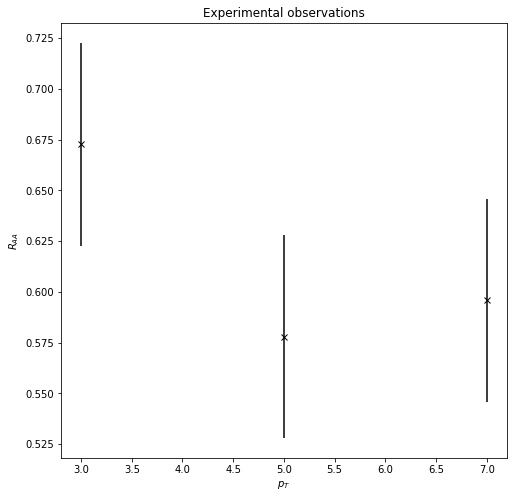

In [6]:
# Set seed for reproducibility.
seed = 42
np.random.seed(seed)

# Generate some synthetic data from the model.
x = np.array(pT_obs)
N = len(x)
obserr = 0.05 # Amplitude of noise term
obs = simulation(truth, *pT_range)[:,pT_obs] # True model
obs += obserr * np.random.randn(N) # Add some random noise

# Now plot it to see what the data looks like
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x.flatten(), obs.flatten(), yerr=obserr, fmt="xk", capsize=0)
#ax.plot(x.flatten(), obs.flatten(), "k", alpha=0.3, lw=3)
#ax.set_xlim(0, 10)
ax.set_xlabel(r"$p_T$")
ax.set_ylabel(r"$R_{AA}$")
ax.set_title('Experimental observations')

In [7]:
# Define the loglikelihood function
def logLikelihood(theta, x, obs, obserr):
  
    # Model parameters
    theta = np.array(theta)
    alpha_s, mD_factor, exponent_inel, exponent_el = theta
    design = np.array([alpha_s, mD_factor, exponent_inel, exponent_el]).reshape(1,-1)
    # Model predictions given parameters
    model = simulation(design, *pT_range)[:,x]
    
    # Likelihood of data given model parameters
    return -0.5*np.sum((obs-model)**2/obserr**2)

In [8]:
# Define the logprior function
def logPrior(theta):
    
    # Model parameters
    theta = np.array(theta)
    alpha_s, mD_factor, exponent_inel, exponent_el = theta
    
    # Probability of model parameters: flat prior
    if prior_ranges['alpha_s'][0] < alpha_s < prior_ranges['alpha_s'][1] \
        and prior_ranges['mD_factor'][0] < mD_factor < prior_ranges['mD_factor'][1] \
        and prior_ranges['exponent_inel'][0] < exponent_inel < prior_ranges['exponent_inel'][1] \
        and prior_ranges['exponent_el'][0] < exponent_el < prior_ranges['exponent_el'][1]:
        return 0.0
    return -np.inf

In [9]:
# Define logprobability function: l(D|theta) * p(theta)
# Note: use this for emcee, not approxposterior!
def logProbability(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(theta, x, obs, obserr)

**Inference with ```approxposterior```**

---

Now let's see if we can derive similar constraints using ```approxposterior```.

First, ```approxposterior``` requires a function that samples model parameters from the prior distributions.

In [10]:
def sampleFunction(n):
    """
    docs

    Parameters
    ----------
    n : int
        Number of samples

    Returns
    -------
    sample : floats
        n x 4 array of floats samples from the prior
    """

    # Sample model parameters given prior distributions
    alpha_s = np.random.uniform(*prior_ranges['alpha_s'], size=(n))
    mD_norm = np.random.uniform(*prior_ranges['mD_factor'], size=(n))
    exponent_inel = np.random.uniform(*prior_ranges['exponent_inel'], size=(n))
    exponent_el = np.random.uniform(*prior_ranges['exponent_el'], size=(n))
    
    return np.array([alpha_s, mD_norm, exponent_inel, exponent_el]).T

Define the ```approxposterior``` parameters.

In [11]:
# Define algorithm parameters
m0 = 5                           # Initial size of training set
m = 10                            # Number of new points to find each iteration
nmax = 10                          # Maximum number of iterations
bounds = list(prior_ranges.values())    # Prior bounds
algorithm = "bape"                # Use the Kandasamy et al. (2017) formalism

# emcee MCMC parameters: Use the same MCMC parameters as the emcee-only analysis
samplerKwargs = {"nwalkers" : 10}  # emcee.EnsembleSampler parameters
mcmcKwargs = {"iterations" : 5000} # emcee.EnsembleSampler.run_mcmc parameters

# Data and uncertainties that we use to condition our model
args = (x, obs, obserr)

Here we create the initial training set by running the true forward model $m_0$ times.  ```approxposterior``` learns on this training set and, each iteration, runs the forward model $m$ additional times in regions of parameter space that will most improve its owns predictive performance, iteratively improving the posterior distribution estimate.

In [12]:
# Create a training set to condition the GP

# Randomly sample initial conditions from the prior
theta = np.array(sampleFunction(m0))

# Evaluate forward model to compute log likelihood + lnprior for each theta
y = list()
for ii in range(len(theta)):
    y.append(logLikelihood(theta[ii,:], *args) + logPrior(theta[ii,:]))
y = np.array(y)

# We'll create the initial GP using approxposterior's built-in default
# initialization.  This default typically works well in many applications.
gp = gpu.defaultGP(theta, y)

Working on 1/1 design
Working on 1/1 design
Working on 1/1 design
Working on 1/1 design


/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:42: RuntimeWarning: invalid value encountered in log
  log_P_g_prev=np.log(P_g)
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:74: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res_quad2c=scipy.integrate.quad(vec_integrand, p, pmax, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res_quad2b=scipy.integrate.quad(lambda u, p=p: p*integrand_middle(p,u), 0, delta, limit=npts, epsabs=epsabs, epsrel=epsrel)
/Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:79: IntegrationWarning: The occurrence of roundoff error is de

Working on 1/1 design


Now initialize the ```ApproxPosterior``` object and we're ready to go!

In [13]:
ap = approx.ApproxPosterior(theta=theta,                   # Initial model parameters for inputs
                            y=y,                           # Logprobability of each input
                            gp=gp,                         # Initialize Gaussian Process
                            lnprior=logPrior,              # logprior function
                            lnlike=logLikelihood,          # loglikelihood function
                            priorSample=sampleFunction,    # Prior sample function
                            algorithm=algorithm,           # bape, agp, or alternate
                            bounds=bounds)                 # Parameter bounds

Run ```approxposterior```! Note that we set cache to False so ```approxposterior``` only saves the most recent sampler and MCMC chain instead of saving each full MCMC chain to a local HD5f file (see emcee v3 documentation for more details on how emcee caches data).

In [14]:
# Run!
ap.run(m=m, nmax=nmax,estBurnin=True, mcmcKwargs=mcmcKwargs, cache=False,
       samplerKwargs=samplerKwargs, verbose=False, args=args, onlyLastMCMC=False,
       seed=seed, optGPEveryN = 10, convergenceCheck=True)

/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
  0%|          | 0/10 [00:00<?, ?it/s]

Working on 1/1 design


/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/optimize/optimize.py:2522: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
 10%|█         | 1/10 [00:17<02:41, 17.92s/it]

hyperparameters [-1.27933757e+02 -6.31197745e+00 -1.19226852e-01  6.38275963e-01
  4.62632517e-01]
Working on 1/1 design


 20%|██        | 2/10 [00:29<01:54, 14.37s/it]

hyperparameters [-105.31283082   -2.64128094   20.            6.25739768   -1.13724415]
Working on 1/1 design


 30%|███       | 3/10 [02:51<08:26, 72.34s/it]

hyperparameters [-105.31283082   -2.64128094   20.            6.25739768   -1.13724415]
Working on 1/1 design


 40%|████      | 4/10 [03:06<04:58, 49.67s/it]

hyperparameters [-105.31283082   -2.64128094   20.            6.25739768   -1.13724415]
Working on 1/1 design


 50%|█████     | 5/10 [03:24<03:11, 38.26s/it]

hyperparameters [-105.31283082   -2.64128094   20.            6.25739768   -1.13724415]
Working on 1/1 design


 60%|██████    | 6/10 [03:41<02:05, 31.34s/it]

hyperparameters [-105.31283082   -2.64128094   20.            6.25739768   -1.13724415]
Working on 1/1 design


 70%|███████   | 7/10 [04:09<01:29, 29.95s/it]

hyperparameters [-105.31283082   -2.64128094   20.            6.25739768   -1.13724415]
Working on 1/1 design


 80%|████████  | 8/10 [04:20<00:48, 24.16s/it]

hyperparameters [-105.31283082   -2.64128094   20.            6.25739768   -1.13724415]
Working on 1/1 design


 90%|█████████ | 9/10 [04:32<00:20, 20.33s/it]

hyperparameters [-105.31283082   -2.64128094   20.            6.25739768   -1.13724415]


100%|██████████| 10/10 [04:48<00:00, 28.82s/it]

Working on 1/1 design
hyperparameters [-105.31283082   -2.64128094   20.            6.25739768   -1.13724415]



  0%|          | 0/10 [00:00<?, ?it/s]

Working on 1/1 design


 10%|█         | 1/10 [00:49<07:26, 49.60s/it]

hyperparameters [-105.31283082   -2.64128094   20.            6.25739768   -1.13724415]
Working on 1/1 design


 20%|██        | 2/10 [01:04<03:55, 29.45s/it]

hyperparameters [-147.61356795   -6.47944684    1.10632139    3.15804623    6.05220442]
Working on 1/1 design


 30%|███       | 3/10 [01:19<02:38, 22.71s/it]

hyperparameters [-147.61356795   -6.47944684    1.10632139    3.15804623    6.05220442]
Working on 1/1 design


 40%|████      | 4/10 [01:40<02:12, 22.12s/it]

hyperparameters [-147.61356795   -6.47944684    1.10632139    3.15804623    6.05220442]
Working on 1/1 design


 50%|█████     | 5/10 [01:58<01:43, 20.66s/it]

hyperparameters [-147.61356795   -6.47944684    1.10632139    3.15804623    6.05220442]
Working on 1/1 design


 60%|██████    | 6/10 [02:17<01:19, 19.79s/it]

hyperparameters [-147.61356795   -6.47944684    1.10632139    3.15804623    6.05220442]
Working on 1/1 design


 70%|███████   | 7/10 [02:38<01:00, 20.29s/it]

hyperparameters [-147.61356795   -6.47944684    1.10632139    3.15804623    6.05220442]
Working on 1/1 design


 80%|████████  | 8/10 [02:59<00:41, 20.57s/it]

hyperparameters [-147.61356795   -6.47944684    1.10632139    3.15804623    6.05220442]
Working on 1/1 design


 90%|█████████ | 9/10 [03:14<00:18, 18.89s/it]

hyperparameters [-147.61356795   -6.47944684    1.10632139    3.15804623    6.05220442]
Working on 1/1 design


100%|██████████| 10/10 [03:36<00:00, 21.61s/it]

hyperparameters [-147.61356795   -6.47944684    1.10632139    3.15804623    6.05220442]



  0%|          | 0/10 [00:00<?, ?it/s]

Working on 1/1 design


 10%|█         | 1/10 [00:18<02:44, 18.24s/it]

hyperparameters [-147.61356795   -6.47944684    1.10632139    3.15804623    6.05220442]
Working on 1/1 design


 20%|██        | 2/10 [00:36<02:25, 18.20s/it]

hyperparameters [-131.61434946   -6.65491681    0.97434829    5.15353425    3.42550153]
Working on 1/1 design


 30%|███       | 3/10 [00:51<01:57, 16.78s/it]

hyperparameters [-131.61434946   -6.65491681    0.97434829    5.15353425    3.42550153]
Working on 1/1 design


 40%|████      | 4/10 [01:13<01:51, 18.65s/it]

hyperparameters [-131.61434946   -6.65491681    0.97434829    5.15353425    3.42550153]
Working on 1/1 design


 50%|█████     | 5/10 [01:31<01:32, 18.49s/it]

hyperparameters [-131.61434946   -6.65491681    0.97434829    5.15353425    3.42550153]
Working on 1/1 design


 60%|██████    | 6/10 [01:46<01:09, 17.34s/it]

hyperparameters [-131.61434946   -6.65491681    0.97434829    5.15353425    3.42550153]
Working on 1/1 design


 70%|███████   | 7/10 [02:04<00:53, 17.68s/it]

hyperparameters [-131.61434946   -6.65491681    0.97434829    5.15353425    3.42550153]
Working on 1/1 design


 80%|████████  | 8/10 [02:19<00:33, 16.83s/it]

hyperparameters [-131.61434946   -6.65491681    0.97434829    5.15353425    3.42550153]
Working on 1/1 design


 90%|█████████ | 9/10 [02:38<00:17, 17.34s/it]

hyperparameters [-131.61434946   -6.65491681    0.97434829    5.15353425    3.42550153]
Working on 1/1 design


100%|██████████| 10/10 [02:59<00:00, 17.94s/it]

hyperparameters [-131.61434946   -6.65491681    0.97434829    5.15353425    3.42550153]



  0%|          | 0/10 [00:00<?, ?it/s]

Working on 1/1 design


 10%|█         | 1/10 [00:18<02:44, 18.31s/it]

hyperparameters [-131.61434946   -6.65491681    0.97434829    5.15353425    3.42550153]
Working on 1/1 design


 20%|██        | 2/10 [00:36<02:26, 18.31s/it]

hyperparameters [-124.56413579   -6.5838725     1.05336211    4.3938674     2.62687554]
Working on 1/1 design


 30%|███       | 3/10 [00:57<02:17, 19.67s/it]

hyperparameters [-124.56413579   -6.5838725     1.05336211    4.3938674     2.62687554]
Working on 1/1 design


 40%|████      | 4/10 [01:16<01:54, 19.13s/it]

hyperparameters [-124.56413579   -6.5838725     1.05336211    4.3938674     2.62687554]
Working on 1/1 design


 50%|█████     | 5/10 [01:37<01:39, 19.91s/it]

hyperparameters [-124.56413579   -6.5838725     1.05336211    4.3938674     2.62687554]
Working on 1/1 design


 60%|██████    | 6/10 [01:52<01:13, 18.28s/it]

hyperparameters [-124.56413579   -6.5838725     1.05336211    4.3938674     2.62687554]
Working on 1/1 design


 70%|███████   | 7/10 [02:10<00:54, 18.21s/it]

hyperparameters [-124.56413579   -6.5838725     1.05336211    4.3938674     2.62687554]
Working on 1/1 design


 80%|████████  | 8/10 [02:28<00:36, 18.20s/it]

hyperparameters [-124.56413579   -6.5838725     1.05336211    4.3938674     2.62687554]
Working on 1/1 design


 90%|█████████ | 9/10 [02:44<00:17, 17.27s/it]

hyperparameters [-124.56413579   -6.5838725     1.05336211    4.3938674     2.62687554]
Working on 1/1 design


100%|██████████| 10/10 [03:05<00:00, 18.55s/it]

hyperparameters [-124.56413579   -6.5838725     1.05336211    4.3938674     2.62687554]



  0%|          | 0/10 [00:00<?, ?it/s]

Working on 1/1 design


 10%|█         | 1/10 [00:15<02:23, 15.90s/it]

hyperparameters [-124.56413579   -6.5838725     1.05336211    4.3938674     2.62687554]
Working on 1/1 design


 20%|██        | 2/10 [00:31<02:04, 15.51s/it]

hyperparameters [-117.83538542   -6.94102832    0.74612917    5.16302229    3.09395443]
Working on 1/1 design


 30%|███       | 3/10 [00:46<01:48, 15.51s/it]

hyperparameters [-117.83538542   -6.94102832    0.74612917    5.16302229    3.09395443]
Working on 1/1 design


 40%|████      | 4/10 [01:04<01:38, 16.44s/it]

hyperparameters [-117.83538542   -6.94102832    0.74612917    5.16302229    3.09395443]
Working on 1/1 design


 50%|█████     | 5/10 [01:19<01:19, 15.88s/it]

hyperparameters [-117.83538542   -6.94102832    0.74612917    5.16302229    3.09395443]
Working on 1/1 design


 60%|██████    | 6/10 [01:34<01:02, 15.71s/it]

hyperparameters [-117.83538542   -6.94102832    0.74612917    5.16302229    3.09395443]
Working on 1/1 design


 70%|███████   | 7/10 [01:50<00:46, 15.59s/it]

hyperparameters [-117.83538542   -6.94102832    0.74612917    5.16302229    3.09395443]
Working on 1/1 design


 80%|████████  | 8/10 [02:05<00:30, 15.47s/it]

hyperparameters [-117.83538542   -6.94102832    0.74612917    5.16302229    3.09395443]
Working on 1/1 design


 90%|█████████ | 9/10 [02:21<00:15, 15.55s/it]

hyperparameters [-117.83538542   -6.94102832    0.74612917    5.16302229    3.09395443]
Working on 1/1 design


100%|██████████| 10/10 [02:37<00:00, 15.74s/it]

hyperparameters [-117.83538542   -6.94102832    0.74612917    5.16302229    3.09395443]



  0%|          | 0/10 [00:00<?, ?it/s]

Working on 1/1 design


 10%|█         | 1/10 [00:15<02:17, 15.31s/it]

hyperparameters [-117.83538542   -6.94102832    0.74612917    5.16302229    3.09395443]
Working on 1/1 design


 20%|██        | 2/10 [00:30<02:03, 15.41s/it]

hyperparameters [-100.03192808   -6.95239609    1.01030762    2.68616215    2.37757533]
Working on 1/1 design


 30%|███       | 3/10 [00:46<01:47, 15.32s/it]

hyperparameters [-100.03192808   -6.95239609    1.01030762    2.68616215    2.37757533]
Working on 1/1 design


 40%|████      | 4/10 [01:05<01:41, 16.89s/it]

hyperparameters [-100.03192808   -6.95239609    1.01030762    2.68616215    2.37757533]
Working on 1/1 design


 50%|█████     | 5/10 [01:20<01:21, 16.27s/it]

hyperparameters [-100.03192808   -6.95239609    1.01030762    2.68616215    2.37757533]
Working on 1/1 design


 60%|██████    | 6/10 [01:36<01:05, 16.35s/it]

hyperparameters [-100.03192808   -6.95239609    1.01030762    2.68616215    2.37757533]
Working on 1/1 design


 70%|███████   | 7/10 [01:58<00:54, 18.03s/it]

hyperparameters [-100.03192808   -6.95239609    1.01030762    2.68616215    2.37757533]
Working on 1/1 design


 80%|████████  | 8/10 [02:13<00:34, 17.11s/it]

hyperparameters [-100.03192808   -6.95239609    1.01030762    2.68616215    2.37757533]
Working on 1/1 design


 90%|█████████ | 9/10 [02:28<00:16, 16.50s/it]

hyperparameters [-100.03192808   -6.95239609    1.01030762    2.68616215    2.37757533]
Working on 1/1 design


100%|██████████| 10/10 [02:50<00:00, 17.00s/it]

hyperparameters [-100.03192808   -6.95239609    1.01030762    2.68616215    2.37757533]



  0%|          | 0/10 [00:00<?, ?it/s]

Working on 1/1 design


 10%|█         | 1/10 [00:15<02:18, 15.42s/it]

hyperparameters [-100.03192808   -6.95239609    1.01030762    2.68616215    2.37757533]
Working on 1/1 design


 20%|██        | 2/10 [00:33<02:15, 16.89s/it]

hyperparameters [-74.30056809  -7.52309318  -3.28062138   4.17758332   4.29870865]
Working on 1/1 design


 30%|███       | 3/10 [00:51<02:02, 17.53s/it]

hyperparameters [-74.30056809  -7.52309318  -3.28062138   4.17758332   4.29870865]
Working on 1/1 design


 40%|████      | 4/10 [01:09<01:46, 17.76s/it]

hyperparameters [-74.30056809  -7.52309318  -3.28062138   4.17758332   4.29870865]
Working on 1/1 design


 50%|█████     | 5/10 [01:27<01:29, 17.90s/it]

hyperparameters [-74.30056809  -7.52309318  -3.28062138   4.17758332   4.29870865]
Working on 1/1 design


 60%|██████    | 6/10 [01:48<01:15, 18.97s/it]

hyperparameters [-74.30056809  -7.52309318  -3.28062138   4.17758332   4.29870865]
Working on 1/1 design


 70%|███████   | 7/10 [02:07<00:56, 18.77s/it]

hyperparameters [-74.30056809  -7.52309318  -3.28062138   4.17758332   4.29870865]
Working on 1/1 design


 80%|████████  | 8/10 [02:22<00:35, 17.56s/it]

hyperparameters [-74.30056809  -7.52309318  -3.28062138   4.17758332   4.29870865]
Working on 1/1 design


 90%|█████████ | 9/10 [08:57<02:15, 135.56s/it]

hyperparameters [-74.30056809  -7.52309318  -3.28062138   4.17758332   4.29870865]
Working on 1/1 design


100%|██████████| 10/10 [09:15<00:00, 55.53s/it]

hyperparameters [-74.30056809  -7.52309318  -3.28062138   4.17758332   4.29870865]



  0%|          | 0/10 [00:00<?, ?it/s]

Working on 1/1 design


 10%|█         | 1/10 [00:18<02:43, 18.20s/it]

hyperparameters [-74.30056809  -7.52309318  -3.28062138   4.17758332   4.29870865]
Working on 1/1 design


 20%|██        | 2/10 [00:33<02:12, 16.50s/it]

hyperparameters [-82.01419567  -7.2435334    0.62789758  -0.15445057   3.94215155]
Working on 1/1 design


 30%|███       | 3/10 [00:48<01:51, 15.91s/it]

hyperparameters [-82.01419567  -7.2435334    0.62789758  -0.15445057   3.94215155]
Working on 1/1 design


 40%|████      | 4/10 [01:03<01:33, 15.62s/it]

hyperparameters [-82.01419567  -7.2435334    0.62789758  -0.15445057   3.94215155]
Working on 1/1 design


 50%|█████     | 5/10 [01:16<01:12, 14.43s/it]

hyperparameters [-82.01419567  -7.2435334    0.62789758  -0.15445057   3.94215155]
Working on 1/1 design


 60%|██████    | 6/10 [01:31<00:58, 14.62s/it]

hyperparameters [-82.01419567  -7.2435334    0.62789758  -0.15445057   3.94215155]
Working on 1/1 design


 70%|███████   | 7/10 [01:46<00:44, 14.82s/it]

hyperparameters [-82.01419567  -7.2435334    0.62789758  -0.15445057   3.94215155]
Working on 1/1 design


 80%|████████  | 8/10 [01:59<00:28, 14.22s/it]

hyperparameters [-82.01419567  -7.2435334    0.62789758  -0.15445057   3.94215155]
Working on 1/1 design


 90%|█████████ | 9/10 [02:20<00:16, 16.45s/it]

hyperparameters [-82.01419567  -7.2435334    0.62789758  -0.15445057   3.94215155]
Working on 1/1 design


100%|██████████| 10/10 [02:39<00:00, 15.91s/it]

hyperparameters [-82.01419567  -7.2435334    0.62789758  -0.15445057   3.94215155]



  0%|          | 0/10 [00:00<?, ?it/s]

Working on 1/1 design


 10%|█         | 1/10 [00:15<02:19, 15.51s/it]

hyperparameters [-82.01419567  -7.2435334    0.62789758  -0.15445057   3.94215155]
Working on 1/1 design


 20%|██        | 2/10 [00:33<02:16, 17.08s/it]

hyperparameters [-75.15697692  -7.50548177  -3.50394891   5.55866515   4.27638605]
Working on 1/1 design


 30%|███       | 3/10 [00:51<02:02, 17.56s/it]

hyperparameters [-75.15697692  -7.50548177  -3.50394891   5.55866515   4.27638605]
Working on 1/1 design


 40%|████      | 4/10 [01:06<01:39, 16.57s/it]

hyperparameters [-75.15697692  -7.50548177  -3.50394891   5.55866515   4.27638605]
Working on 1/1 design


 50%|█████     | 5/10 [03:12<04:40, 56.04s/it]

hyperparameters [-75.15697692  -7.50548177  -3.50394891   5.55866515   4.27638605]
Working on 1/1 design


 60%|██████    | 6/10 [03:30<02:52, 43.11s/it]

hyperparameters [-75.15697692  -7.50548177  -3.50394891   5.55866515   4.27638605]
Working on 1/1 design


 70%|███████   | 7/10 [03:52<01:47, 35.96s/it]

hyperparameters [-75.15697692  -7.50548177  -3.50394891   5.55866515   4.27638605]
Working on 1/1 design


 80%|████████  | 8/10 [04:07<00:58, 29.27s/it]

hyperparameters [-75.15697692  -7.50548177  -3.50394891   5.55866515   4.27638605]
Working on 1/1 design


 90%|█████████ | 9/10 [04:28<00:26, 26.73s/it]

hyperparameters [-75.15697692  -7.50548177  -3.50394891   5.55866515   4.27638605]
Working on 1/1 design


100%|██████████| 10/10 [04:49<00:00, 28.94s/it]

hyperparameters [-75.15697692  -7.50548177  -3.50394891   5.55866515   4.27638605]



  0%|          | 0/10 [00:00<?, ?it/s]

Working on 1/1 design
hyperparameters [-75.15697692  -7.50548177  -3.50394891   5.55866515   4.27638605]


 10%|█         | 1/10 [00:15<02:17, 15.25s/it]

Working on 1/1 design


 20%|██        | 2/10 [00:30<02:02, 15.34s/it]

hyperparameters [-81.02009564  -7.40759164  -3.47510319   5.60561762   4.51030825]
Working on 1/1 design


 30%|███       | 3/10 [00:49<01:57, 16.79s/it]

hyperparameters [-81.02009564  -7.40759164  -3.47510319   5.60561762   4.51030825]
Working on 1/1 design


 40%|████      | 4/10 [01:04<01:36, 16.14s/it]

hyperparameters [-81.02009564  -7.40759164  -3.47510319   5.60561762   4.51030825]
Working on 1/1 design


 50%|█████     | 5/10 [01:22<01:24, 16.88s/it]

hyperparameters [-81.02009564  -7.40759164  -3.47510319   5.60561762   4.51030825]
Working on 1/1 design


 60%|██████    | 6/10 [01:37<01:05, 16.26s/it]

hyperparameters [-81.02009564  -7.40759164  -3.47510319   5.60561762   4.51030825]
Working on 1/1 design


 70%|███████   | 7/10 [01:53<00:48, 16.03s/it]

hyperparameters [-81.02009564  -7.40759164  -3.47510319   5.60561762   4.51030825]
Working on 1/1 design


 80%|████████  | 8/10 [02:11<00:33, 16.68s/it]

hyperparameters [-81.02009564  -7.40759164  -3.47510319   5.60561762   4.51030825]
Working on 1/1 design


 90%|█████████ | 9/10 [02:29<00:17, 17.10s/it]

hyperparameters [-81.02009564  -7.40759164  -3.47510319   5.60561762   4.51030825]
Working on 1/1 design


100%|██████████| 10/10 [02:47<00:00, 16.75s/it]

hyperparameters [-81.02009564  -7.40759164  -3.47510319   5.60561762   4.51030825]


let's plot the joint and marginal posterior probability distributions to see how ```approxposterior``` did. In addition, as red points, we'll plot where ```approxposterior``` decided to evaluate the forward model to improve its own performance.  As you'll see below, ```approxposterior``` preferentially runs the forward model in regions of high posterior probability density - it doesn't waste time on low likelihood regions of parameter space!

In [17]:
sample_temp = ap.sampler.get_chain()

In [18]:
sample_temp.shape

(5000, 10, 4)

In [19]:
np.save('4param_chain', sample_temp)

In [22]:
# Let's run some more MCMC samples
samplerKwargs = {"nwalkers" : 10}  # emcee.EnsembleSampler parameters
mcmcKwargs = {"iterations" : 100000} # emcee.EnsembleSampler.run_mcmc parameters
more_ap = ap.runMCMC(samplerKwargs = samplerKwargs, mcmcKwargs = mcmcKwargs, cache = False)

In [25]:
sample_more = ap.sampler.get_chain()

In [26]:
sample_more.shape

(100000, 10, 4)

In [27]:
np.save('4param_chain_more', sample_more)

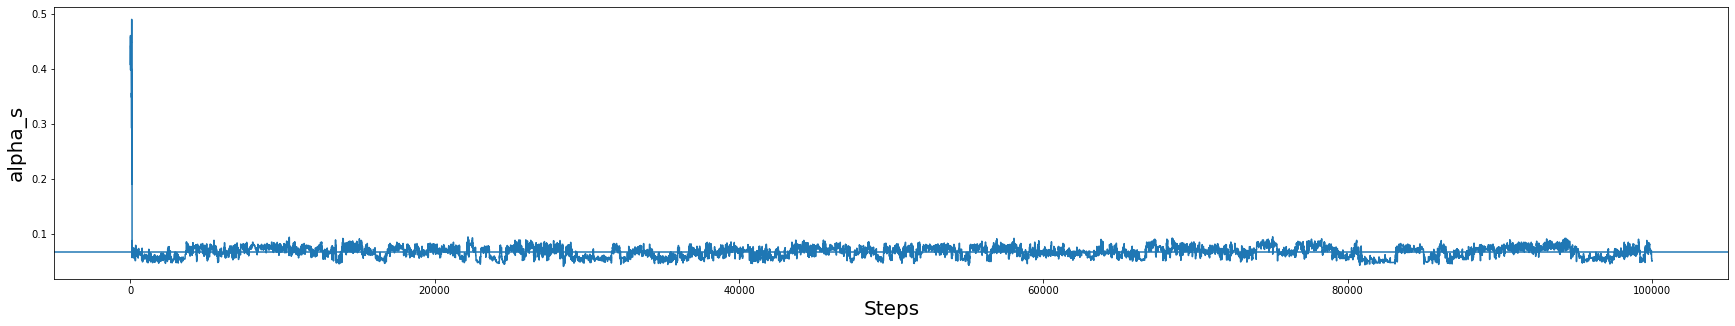

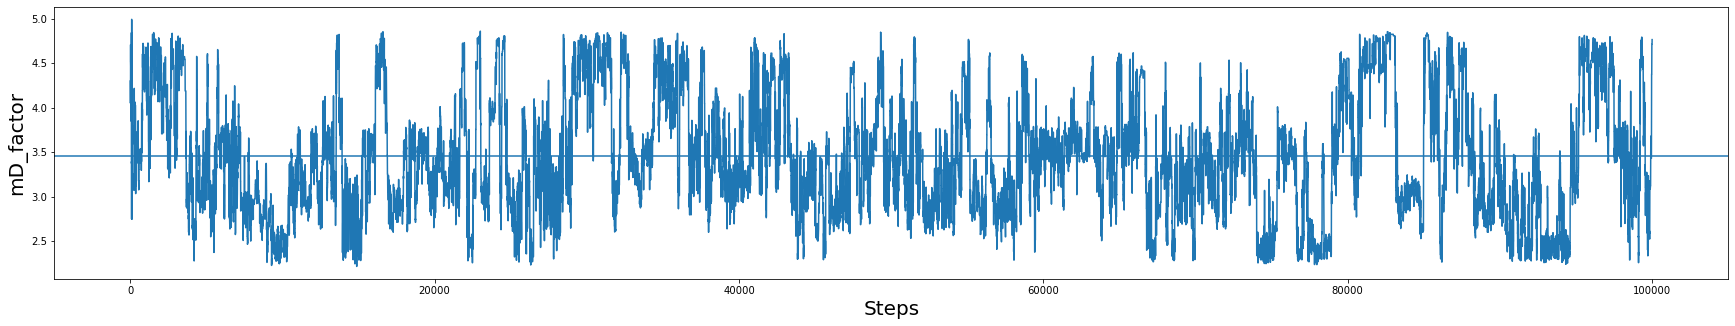

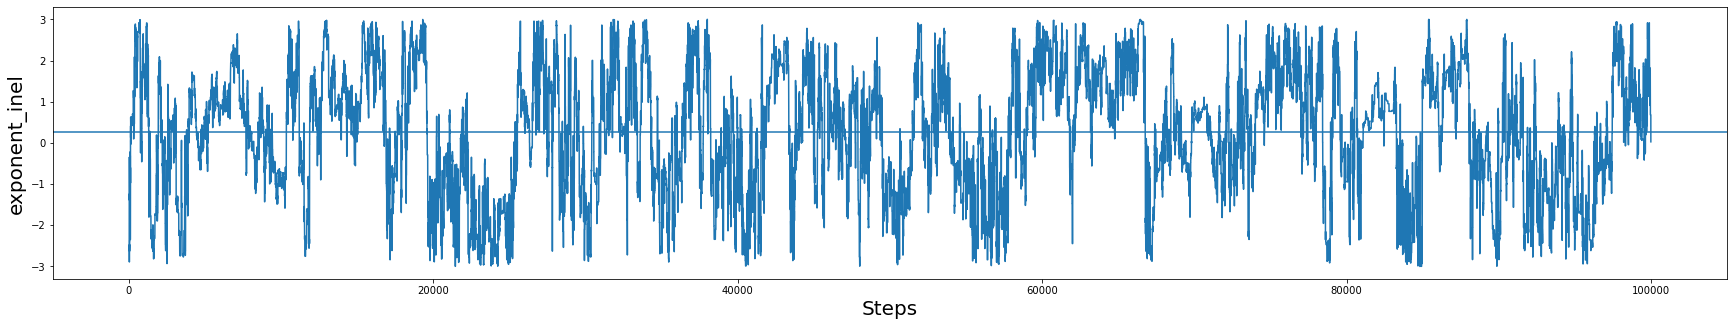

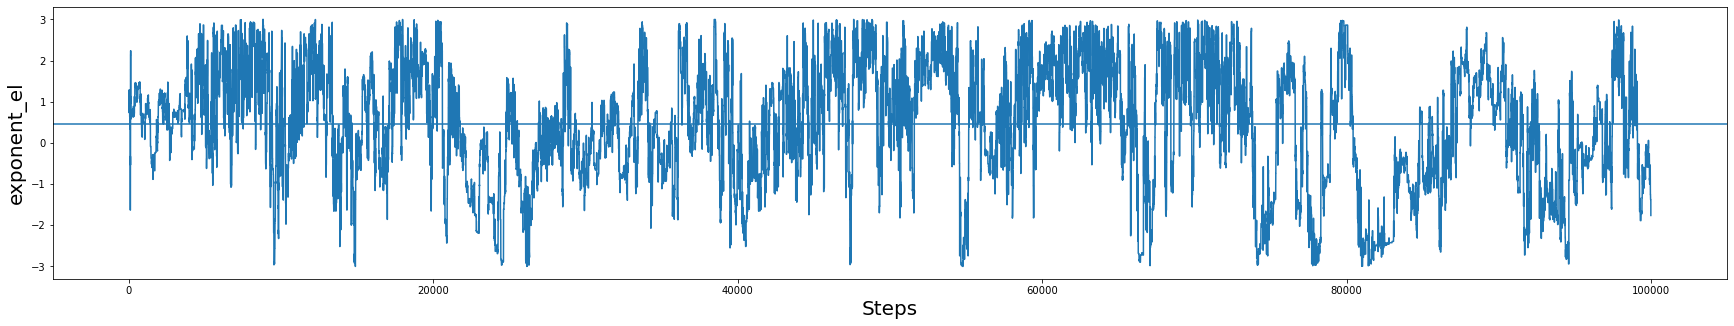

In [63]:
names=list(prior_ranges.keys())
sample_steps = np.arange(0,sample_more.shape[0])
for p, param in enumerate(names):
    fig, ax = plt.subplots(figsize=(30,5))
    ax.plot(sample_steps, sample_more[:,0,p].flatten())
    ax.axhline(y=np.mean(sample_more[:,0,p]))
    ax.set_xlabel('Steps', fontsize = 20)
    ax.set_ylabel(f'{param}', fontsize = 20)

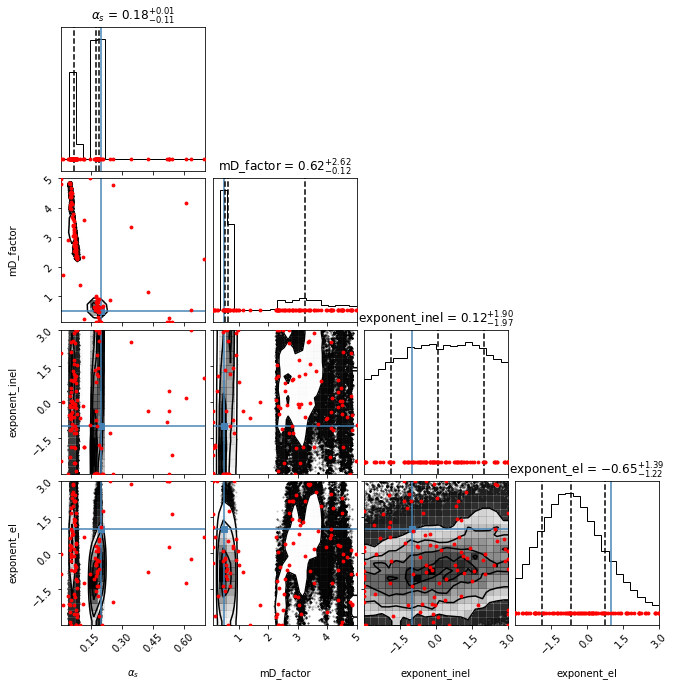

In [44]:
samples = ap.sampler.get_chain(discard=10000, flat=True, thin=1)
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], truths=truth.T,
                    labels=[r"$\alpha_s$", "mD_factor", 'exponent_inel', 'exponent_el'], show_titles=True, scale_hist=True,
                    plot_contours=True, range=(bounds));

# Plot where forward model was evaluated
for row in range(0,4):
    for column in range(0,row+1):
        i=4*row+column
        if row == column:
            fig.axes[i].scatter(ap.theta[:,row],np.zeros(ap.theta[:,row].shape), s=8, color="red", zorder=20)
        else:
            fig.axes[i].scatter(ap.theta[:,column], ap.theta[:,row], s=8, color="red", zorder=20)